<div style="text-align: right"> Cristóbal Silva / crsilva@ing.uchile.cl </div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns

rcParams['axes.labelsize']  = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

SEED = 0
plt.ion()
np.random.seed(SEED)

# Predicción de Diabetes en Indios Pima

El siguiente Notebook corresponde a un proyecto simple de Machine Learning de inicio a fin. El objetivo es predecir si la persona en la muestra tendrá diabetes dentro de los próximos 5 años en base a información general de la persona y exámenes relacionados a la diabetes.

El dataset a utilizar corresponde al [*Pima Indians Diabetes Dataset*](https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes) obtenido el repositorio de datos de UCI. Este set de datos corresponde a datos que fueron donados en el 1990 y corresponde a exámenes realizados a mujeres de origen Pima mayores a 22 años. El contexto del dataset fue estudiar la razón de por qué el pueblo Pima es de los pueblos con mayor tasa de diabetes a nivel mundial.

El primer estudio sobre estos datos fue realizado por [Smith et. al.](http://pubmedcentralcanada.ca/pmcc/articles/PMC2245318/pdf/procascamc00018-0276.pdf), quienes utilizaron una version modificada de una red neuronal denominada ADAP, reportando un $76\%$ de sensibilidad y especificidad cuando se intersectan en función de los umbrales de decisión del modelo.

Los atributos de este dataset son los siguientes:

1. `pregnancies`: Número de veces embarazada
2. `glucose`: Concentración de glucosa en plasma luego de 2 horas en un test oral de tolerancia a glucosa
3. `pressure`: Presión sanguínea diastólica (mm Hg) 
4. `skin`: Grosor de pliegue de piel en triceps (mm) 
5. `insuline`: Nivel de insulina luego de 2 horas después de test de glucosa (mu U/ml) 
6. `bmi`: Índice de Masa Corporal (peso en kg/(altura en m)^2) 
7. `pedigree`: Función de Pedigree de Diabetes
8. `age` : Edad (años) 
9. `label`: Variable de Clase (0 or 1) 

## Cargar Set de Datos

In [2]:
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
cols = ['pregnancies', 'glucose', 'pressure', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
data = pd.read_csv(url, names=cols)

print(data.shape)
data.head()

(768, 9)


,pregnancies,glucose,pressure,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnancies    768 non-null int64
glucose        768 non-null int64
pressure       768 non-null int64
skin           768 non-null int64
insulin        768 non-null int64
bmi            768 non-null float64
pedigree       768 non-null float64
age            768 non-null int64
label          768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.describe()

,pregnancies,glucose,pressure,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Tabla de Contenidos

- [Análisis Exploratorio de Datos](#Análisis-Exploratorio-de-Datos)
  - [Proporción de Etiquetas](#Proporción-de-Etiquetas)
  - [Histogramas](#Histogramas)
  - [Matriz de Correlación](#Matriz-de-Correlación)
- [Conjuntos de Entrenamiento y Prueba](#Conjuntos-de-Entrenamiento-y-Prueba)
- [Modelo Base: Regresión Logística](#Modelo-Base:-Regresión-Logística)
  - [Curva ROC y Curva Precision-Exhaustividad](#Curva-ROC-y-Curva-Precision-Exhaustividad)
- [Evaluando otros Pre-procesamientos](#Evaluando-otros-Pre-procesamientos)
  - [Automatizando Experimentos vía Transformadores de Datos](#Automatizando-Experimentos-vía-Transformadores-de-Datos)
  - [Pipeline 1](#Pipeline-1)
  - [Pipeline 2](#Pipeline-2)
  - [Pipeline 3](#Pipeline-3)
  - [Pipeline 4](#Pipeline-4)
  - [Pipeline 5](#Pipeline-5)
  - [Discusión](#Discusión)
- [Evaluando otros Clasificadores](#Evaluando-otros-Clasificadores)
  - [Support Vector Machines](#Support-Vector-Machines)
  - [Random Forests](#Random-Forests)
  - [Extreme Gradient Boosting](#Extreme-Gradient-Boosting)
  - [Curvas ROC y Curvas Precisión-Exhaustividad](#Curvas-ROC-y-Curvas-Precisión-Exhaustividad)
- [Persistencia de Modelos](#Persistencia-de-Modelos)

Apéndices
- [Apéndice A: Gráficos Adicionales](#Apéndice-A:-Gráficos-Adicionales)
- [Apéndice B: Efecto Semilla](#Apéndice-B:-Efecto-Semilla)

## Análisis Exploratorio de Datos

### Proporción de Etiquetas

Lo primero es revisar como distribuyen las etiquetas de nuestra base de datos, en caso de que exista un desbalance muy grande.

In [5]:
data['label'].value_counts()

0    500
1    268
Name: label, dtype: int64

Podemos ver que en tal caso la relación es 2:1 aproximadamente, por lo que base de datos está desbalanceada a favor de los no-diabéticos. Podemos hacer dos cosas al respecto:

- Crear un sub-conjunto igual con igual número de etiquetas durante el entrenamiento vía Oversampling / Undersampling
- Evaluar con una métrica que tome en cuenta el desbalance (e.g., *precision*, *recall*, *F1-score*)

La primera opción se probará pero es esperable que los resultados no mejoren mucho dado la poca cantidad de muestras existentes para entrenar.

### Histogramas

Haremos una revisión rápida de la distribución de datos mediante histogramas, con el propósito de hacer un análisis cualitativo de estos. Notemos que los histogramas estarán normalizados para tener en cuenta el desbalance de etiquetas.

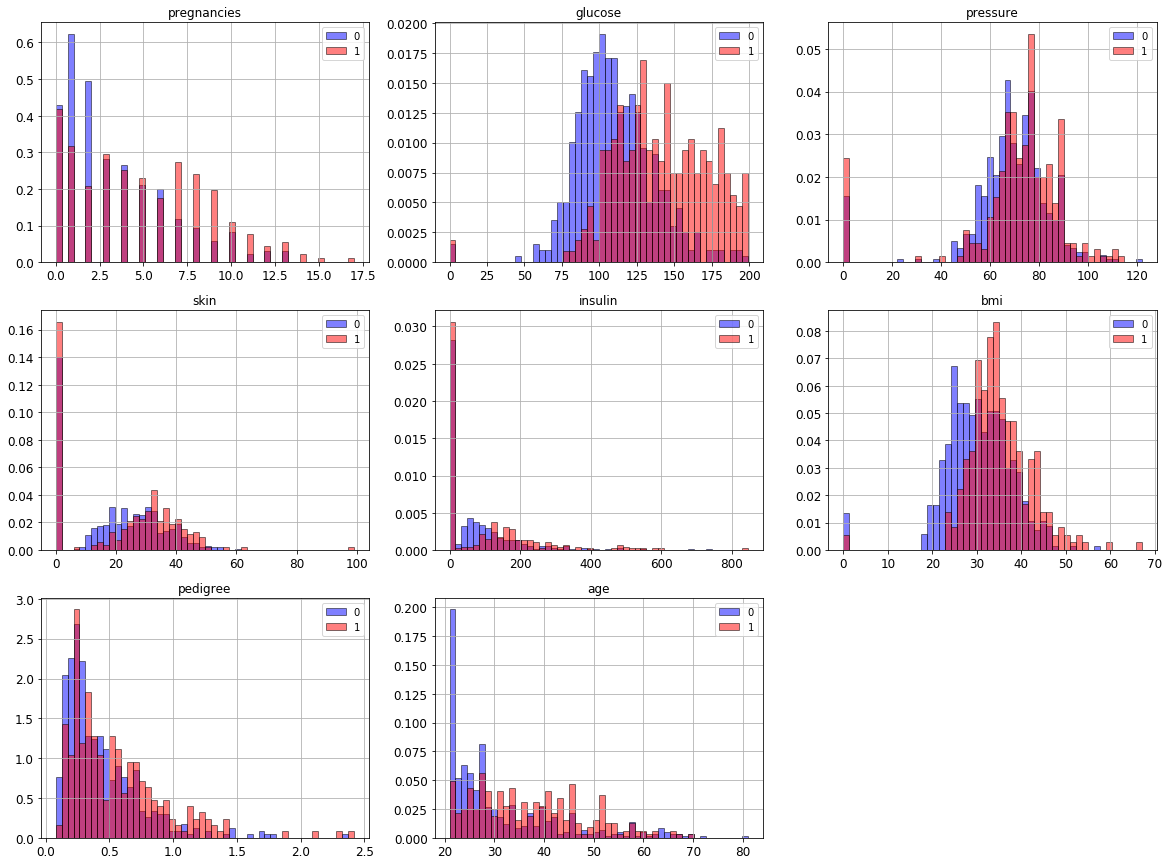

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

axes = axes.ravel()
fig.delaxes(axes[-1])
for i in range(8):
    ax = axes[i]
    col = data.columns[i]
    lower = data[col].min()
    upper = data[col].max()
    data[data['label'] == 0][col].hist(bins=50, color='b', edgecolor='k', alpha=0.5,
                                  range=(lower, upper), ax=ax, label='0', normed=True)
    data[data['label'] == 1][col].hist(bins=50, color='r', edgecolor='k', alpha=0.5,
                                  range=(lower, upper), ax=ax, label='1', normed=True)
    ax.set_title(col)
    ax.legend()

De los histogramas podemos observar que:

- Los siguientes atributos no pueden ser 0: glucosa (`glucose`), presión sanguínea (`pressure`), insulina (`insulin`), índice de masa corporal (`bmi`), grosor de pliegue de piel en triceps (`skin`) [[fuente]](https://medical-dictionary.thefreedictionary.com/triceps+skin-fold+thickness)
- La glucosa tiene una distribución con valores notoriamente más altos para el caso de los diabéticos.

Según la descripción de la base de datos [[fuente]](https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes), estos valores podrían ser equivalentes a NaNs o falta de dato, pero queda a criterio de quien use los datos decidir que hacer al respecto.

Nuevamente, tenemos dos opciones para proseguir:

1. Botar todos los índices que contienen 0 en alguna de estas columnas.
2. Imputar los datos con alguna técnica (e.g. reemplazar por mediana).

Por ahora veremos que ocurre con la opción 1, y una vez tengamos el resultado final probaremos la opción 2 para comparar el desempeño del clasificador.

In [7]:
# Número de 0s por columna
suspect_cols = ['glucose', 'pressure', 'skin', 'insulin', 'bmi']
len(data[suspect_cols]) - data[suspect_cols].astype(bool).sum(axis=0)  # Nº de ceros = Total - No-ceros

glucose       5
pressure     35
skin        227
insulin     374
bmi          11
dtype: int64

#### Eliminar 0s de columnas incongruentes

Veamos que ocurre cuando eliminamos todos los 0 de las columnas problemáticas.

In [8]:
# Obtener índices de datos con 0 y eliminar dichos índices del dataframe
suspect_cols = ['glucose', 'pressure', 'skin', 'insulin', 'bmi']

idx_list = []
for col in suspect_cols:
    query = '{0} == 0'.format(col)
    idx = list(data.query(query).index)
    idx_list += idx
idx_set_1 = set(idx_list)  # evita repetir indices
df_filtered_1 = data.drop(idx_set_1).reset_index(drop=True)

print('Porcentaje de reteción del dataframe: {0:.2f}%'.format(len(df_filtered_1) / len(data) * 100))
labels = df_filtered_1['label'].value_counts()
print('No-Diabeticos / Diabeticos: {0} / {1}'.format(labels[0], labels[1]))

Porcentaje de reteción del dataframe: 51.04%
No-Diabeticos / Diabeticos: 262 / 130


Debido a que las columnas `insuline` y `skin` cotienen una alta cantidad de *missing values*, si eliminamos los índices que contienen 0 en esas columnas perdemos un porcentaje importante de set de datos. Esto no es convienente ya que de por sí la cantidad de muestras es baja.

Veamos que ocurre si derechamente no usamos las columnas `insulin` y `skin` y eliminamos los índices con 0 del resto.

In [9]:
# Obtener índices de datos con 0 y eliminar dichos índices del dataframe
suspect_cols = ['glucose', 'pressure', 'bmi']
df_temp = data.drop(['insulin', 'skin'], axis=1)

idx_list = []
for col in suspect_cols:
    query = '{0} == 0'.format(col)
    idx = list(df_temp.query(query).index)
    idx_list += idx
idx_set_2 = set(idx_list)  # evita repetir indices
df_filtered_2 = df_temp.drop(idx_set_2).reset_index(drop=True)

print('Porcentaje de retención del dataframe: {0:.2f}%'.format(len(df_filtered_2) / len(data) * 100))
labels = df_filtered_2['label'].value_counts()
print('No-Diabeticos / Diabeticos: {0} / {1}'.format(labels[0], labels[1]))

Porcentaje de retención del dataframe: 94.27%
No-Diabeticos / Diabeticos: 475 / 249


En este caso se conserva un porcentaje mucho más alto del set de datos, con el costo de perder dos columnas que pueden o no ser informativas.

### Matriz de Correlación

Antes de decidir cuál de los dos dataframes anteriores utilizar, un análisis rápido de correlaciones podría ayudarnos.

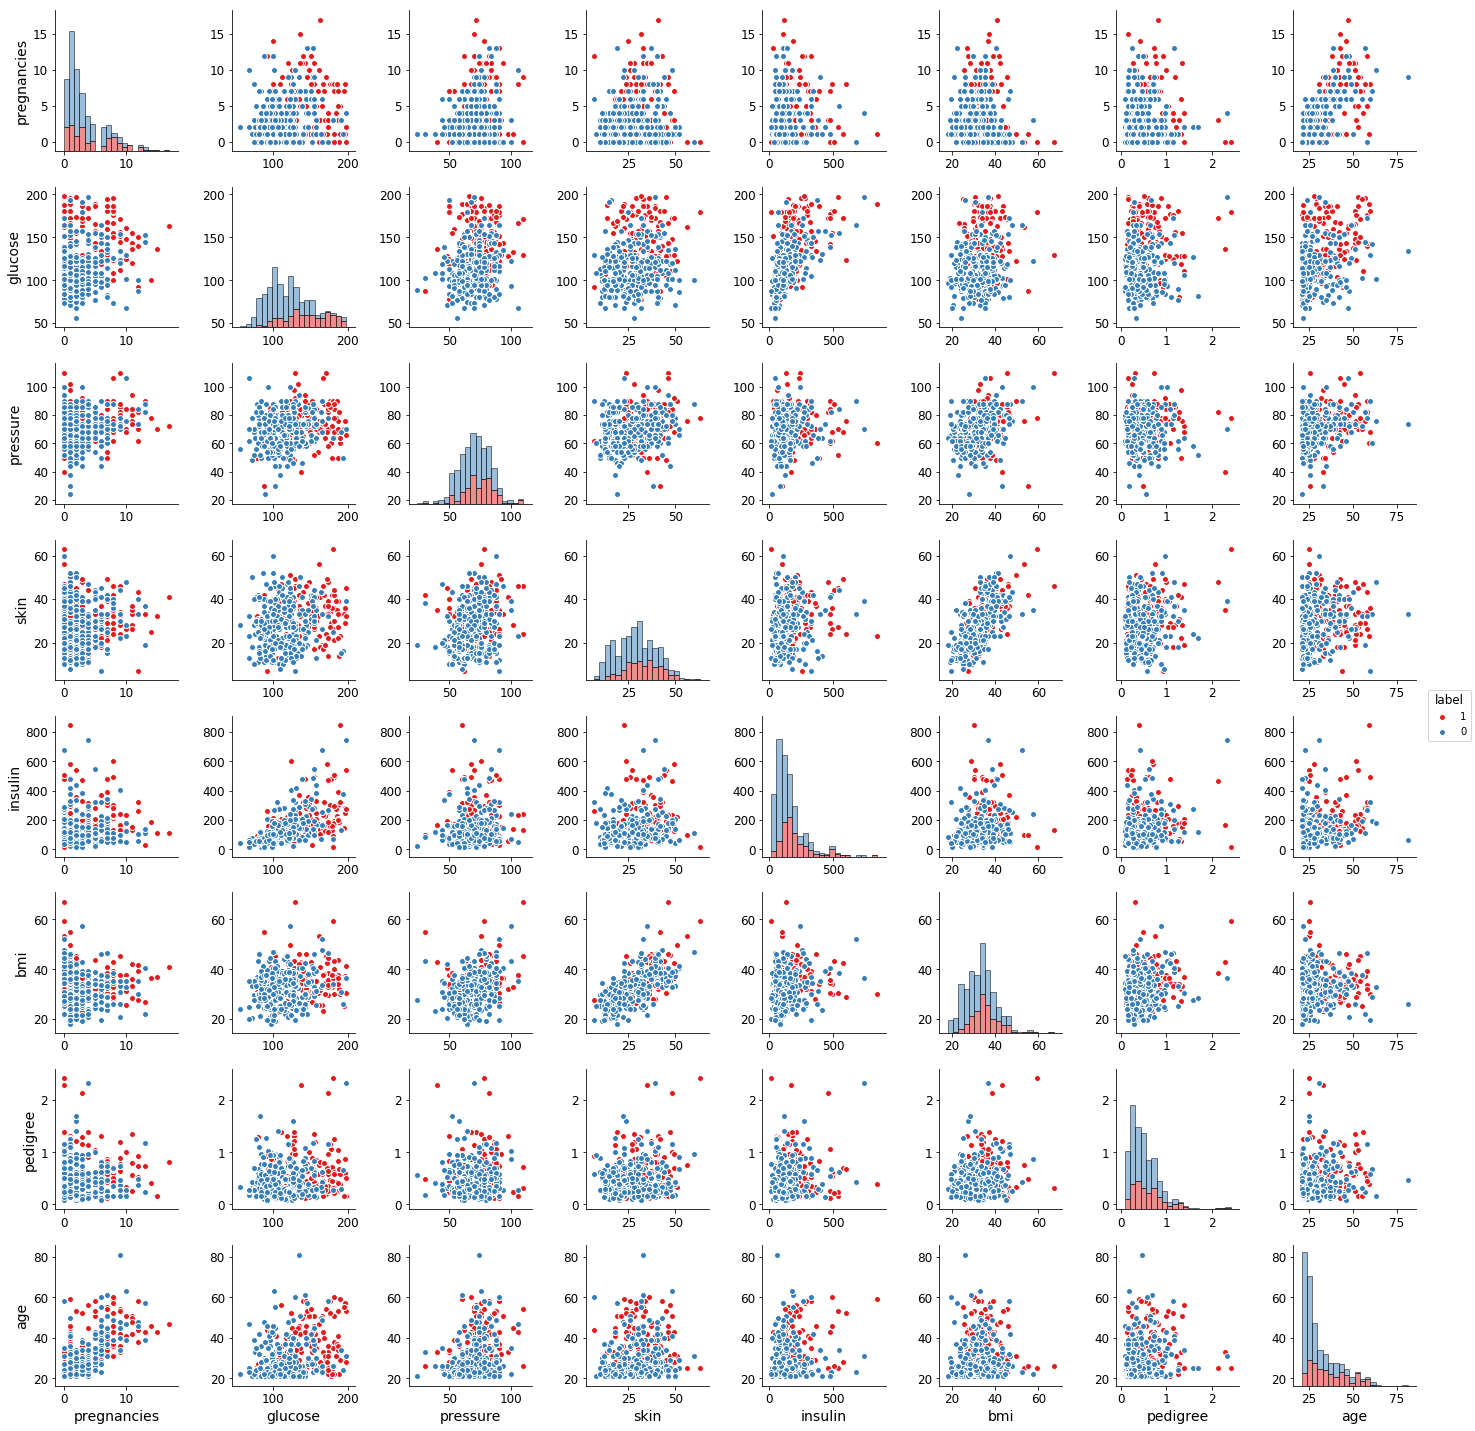

In [10]:
sns.pairplot(df_filtered_1, hue='label', palette='Set1', vars=df_filtered_1.columns.drop('label'), 
             diag_kws={'edgecolor': 'k', 'alpha': 0.5, 'bins': 20, 'normed': False}, hue_order=[1, 0])

Tanto `insulin` como `skin` no parecen tener una separación lineal, aunque a priori se podría decir lo mismo de todas las otras columnas. Para nuestro primer modelo mantendremos la decisión de eliminar estas columnas, y separaramos los datos en conjunto de entrenamiento y prueba.

In [11]:
df_chosen = df_filtered_2

## Conjuntos de Entrenamiento y Prueba

Dejaremos un 80% del conjunto para entrenar, teniendo en consideración el desbalance de clases usando muestreo estratificado.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(df_chosen, df_chosen['label']):
    strat_train_set = df_chosen.loc[train_index]
    strat_test_set = df_chosen.loc[test_index]

Separaremos las clases en un dataframe propio.

In [13]:
train_feats = strat_train_set.drop(['label'], axis=1)
train_class = strat_train_set['label'].copy()

test_feats = strat_test_set.drop(['label'], axis=1)
test_class = strat_test_set['label'].copy()

## Modelo Base: Regresión Logística

Haremos un análisis inicial con una simple regresión logística (con regularización). Analizaremos las propiedades de este caso y luego probaremos otras combinaciones para ver si se puede mejorar el resultado.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logistic_model = LogisticRegression()
logistic_model.fit(train_feats, train_class)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
predictions = logistic_model.predict(test_feats)
print(classification_report(test_class, predictions))

             precision    recall  f1-score   support

          0       0.80      0.87      0.83        95
          1       0.71      0.58      0.64        50

avg / total       0.77      0.77      0.77       145



A priori, un modelo entrenado con los parámetros por defecto y sin validación cruzada alcanza una sensibilidad de 0.82 y una especificidad de 0.54 en el conjunto de prueba. Estos parámetros podrían o no ser suficientes para un clasificador, pero es necesario analizar como el umbral de decisión afecta estos valores. Para ello utilizaremos las curvas Sensibilidad-Especificidad (*ROC*) y Precisión-Exhaustividad (*precision-recall*)

Notemos también que todo esto dependió de una elección aleatoria de los conjuntos de entrenamiento y prueba, y a pesar de estar estratificados, las características usadas para entrenar pueden o no ser más descriptivas que las que existen en el conjunto de prueba. Cambiemos un momento la semilla para ver que ocurre con los resultados:

In [16]:
ALT_SEED = 42
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=ALT_SEED)
for train_index, test_index in split.split(df_chosen, df_chosen['label']):
    strat_train_set = df_chosen.loc[train_index]
    strat_test_set = df_chosen.loc[test_index]

# Repetimos los procedimientos anteriores
train_feats = strat_train_set.drop(['label'], axis=1)
train_class = strat_train_set['label'].copy()
test_feats = strat_test_set.drop(['label'], axis=1)
test_class = strat_test_set['label'].copy()

logistic_model_alt = LogisticRegression()
logistic_model_alt.fit(train_feats, train_class)

predictions = logistic_model_alt.predict(test_feats)
print(classification_report(test_class, predictions))

             precision    recall  f1-score   support

          0       0.77      0.82      0.80        95
          1       0.61      0.54      0.57        50

avg / total       0.72      0.72      0.72       145



En este caso, vemos una diferencia de $5\%$ de exactitud, algo que no es menor. Probablemente con esta semilla las características del conjunto de entrenamiento no son tan descriptivas, o quizás el conjunto de prueba tomó casos más fáciles de clasificar. De cualquier forma, mientras más pequeños nuestros conjuntos de datos, más común será ver este tipo de varianza en los modelos.

### Curva ROC y Curva Precision-Exhaustividad

Antes de proseguir definiremos los siguientes términos:

- $VP$: Verdadero Positivo
- $VN$: Verdadero Negativo
- $FP$: Falso Positivo
- $FN$: Falso Negativo
- Precisión: $VP / (VP + FP)$
- Exhaustividad / Sensibilidad: $VP / (VP + FN)$
- Especificidad: $VN / (VN + FP)$

La curva ROC es una curva de Tasa de Falsos Positivos (1 - Especificidad) vs Tasa de Verdaderos Positivos (Sensibilidad).

La curva Precision-Exhaustividad (P-E) compara directamente las métricas anteriormente definidas.

In [17]:
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, roc_auc_score

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Exhaustividad')
    ax.set_xlabel('Umbral de Puntaje')
    ax.set_xlim([thresholds.min(), thresholds.max()])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_title('Umbral de Puntaje vs Precisión/Exhaustividad')
    
def plot_specificity_sensitivity_vs_threshold(specificity, sensitivity, thresholds, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(thresholds, specificity, 'g-', label='Especificidad')
    ax.plot(thresholds, sensitivity, 'b--', label='Sensibilidad')
    ax.set_xlabel('Umbral de Puntaje')
    ax.set_xlim([thresholds.min(), thresholds.max()])
    ax.set_ylim([0, 1])
    ax.legend()
    ax.set_title('Umbral de Puntaje vs Expecifidad/Sensibilidad')
    
def plot_precision_recall_curve(precision, recall, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(recall, precision, 'm-')
    ax.set_xlabel('Exhaustividad')
    ax.set_ylabel('Precision')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title('Curva Exhaustividad vs Precision')
    
def plot_roc_curve(fpr, tpr, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, 'r-')
    ax.plot([0, 1], [0, 1], 'b--', lw=1, label='_nolegend_')
    ax.set_xlabel('1 - Especificidad / TFP')
    ax.set_ylabel('Sensibilidad / TVP')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title('Curva ROC')

Ambas curvas lo que hacen es mover un umbral de decisión que permite decidir si una clase es positiva o no, dado un puntaje. Este puntaje es un número real, y en el caso de Scikit-Learn corresponde a la distancia desde un punto clasificado hasta el hiper-plano separador de clases.

Como ejemplo, supongamos que el puntaje umbral es $0.5$. Cualquier punta $x > 0.5$ se considerará diabetes, y cualquier valor $x < 0.5$ se considerará no-diabetes. Scikit-Learn aplica este criterio por debajo al momento de entregar predicciones.

En la regresión logística se podría usar también la razón entre las probabilidades de que sea alguna de las dos clases (razón de verosimilitud) y uno podría ajustar este umbral a mano, pero por brevedad dejaremos que la librería se encargue de esto.

In [18]:
scores = logistic_model.decision_function(train_feats)  # puntajes previos a aplicar el umbral

Si bien podríamos usar estos puntajes del modelo recientemente entrenado, utilizaremos una predicción basada en validación cruzada para asegurar mejor capacidad de generalización.

In [19]:
from sklearn.linear_model import LogisticRegressionCV

logistic_model_cv = LogisticRegressionCV(cv=5)
logistic_model_cv.fit(train_feats, train_class)  # modelo + validación cruzada

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [20]:
# scores = cross_val_predict(logistic_model, train_feats, train_class, cv=5, method='decision_function')
scores = logistic_model_cv.decision_function(test_feats)

In [21]:
# curva precision-exhaustividad
precisions, recalls, pr_thresholds = precision_recall_curve(test_class, scores, pos_label=1)

# curva ROC
fpr, tpr, roc_thresholds = roc_curve(test_class, scores, pos_label=1)
roc_score = roc_auc_score(test_class, scores)  # area bajo la curva
ap_score = average_precision_score(test_class, scores)  # precisión promedio

Text(0.5,1,'Curva ROC / Area: 0.75')

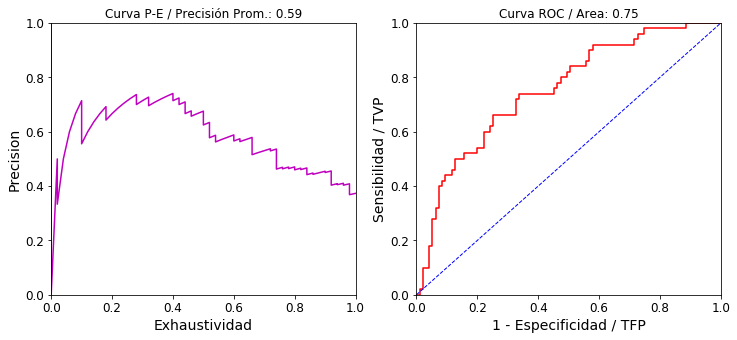

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()
plot_precision_recall_curve(precisions, recalls, axes[0])
plot_roc_curve(fpr, tpr, axes[1])

axes[0].set_title('Curva P-E / Precisión Prom.: {0:.2f}'.format(ap_score))
axes[1].set_title('Curva ROC / Area: {0:.2f}'.format(roc_score))

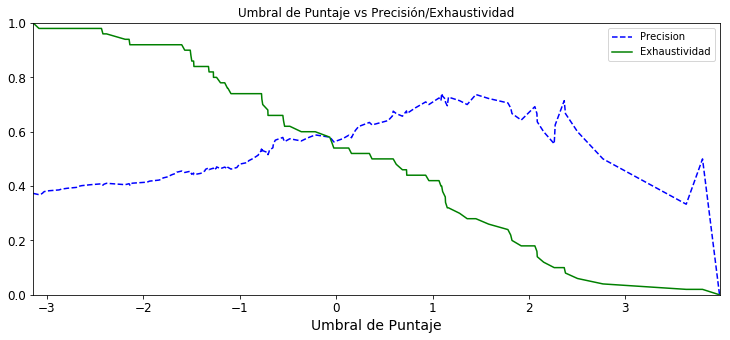

In [23]:
fig, ax = plt.subplots(figsize=(12.3, 5))
plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds, ax=ax)

Valores más cercanos a intersección: 0.660 / 0.674


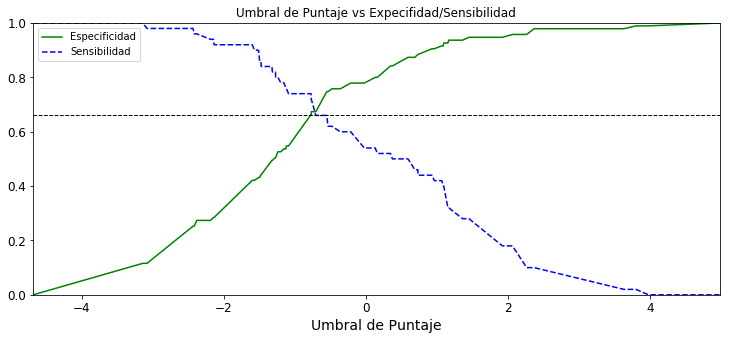

In [24]:
fig, ax = plt.subplots(figsize=(12.3, 5))
plot_specificity_sensitivity_vs_threshold(1 - fpr, tpr, roc_thresholds, ax=ax)

cross_idx = np.where(np.abs(tpr - (1 - fpr)) == np.abs(tpr - (1 - fpr)).min())[0]
ax.axhline(tpr[cross_idx], lw=1, color='k', linestyle='dashed')

# punto de encuentro
print('Valores más cercanos a intersección: {0:.3f} / {1:.3f}'.format(tpr[cross_idx][0], (1 - fpr)[cross_idx][0]))

Podemos ver que en el caso de Sensibilidad vs Especificidad, obtenemos un resultado más bajo que el algoritmo ADAP en el conjunto de prueba, dado que en este las métricas se encuentran $0.76$ (76%) mientras que en la regresión logística esto ocurre en $0.68$ (68%). Como vemos, la diferencia es considerable, por lo que un modelo lineal podría ser inadecuado para este problema.

Dependiendo del criterio que sea necesario utilizar, puede que sea más interesante utilizar una curva sobre otra. Si es más importante no equivocarse en la predicción de diabetes, sería necesario sacrificar especificidad por un mejor valor de sensibilidad.

In [25]:
print('Sensibilidad: {0:.2f} / Especificidad: {1:.2f}'.format(tpr[cross_idx + 4][0], 1 - fpr[cross_idx + 4][0]))

Sensibilidad: 0.74 / Especificidad: 0.55


En general para los casos en que una clase tiene importancia sobre otra, se suele preferir comparar exhaustividad (sensibilidad) y precisión. Una explicación informal pero breve del por qué de esto se puede encontrar en el siguiente [link](https://stats.stackexchange.com/q/7210). Básicamente esta última responde a la pregunta ¿qué tan dispuesto estoy a tener falsos positivos para tener una buena tasa de verdaderos positivos?

## Evaluando otros Pre-procesamientos

Hemos completado en pipeline tomando las siguientes consideraciones:

- Dataset sin columnas `skin` (grosor de piel en triceps) y `insulin` (insulina)
- Dataset sin 0s incongruentes provenientes de `glucose` (glucosa), `pressure` (presión sanguínea) y `bmi` (índice masa corporal).
- Dataset no estandarizado (z-score)
- Regresión Logística con Regularización
- El parámetro de regularización ($C$) se aprende con validación cruzada usando 5 sub-conjuntos ($K=5$)

Ahora diseñaremos un *pipeline* automatizado que permita probar varias combinaciones de clasificadores, datasets e hiper-parámetros.

### Automatizando Experimentos vía Transformadores de Datos

En esta sección definiremos una serie de transformaciones que nos serán de utilidad para pre-procesar los datos evitando repetir mucho código. Por otro lado, es buena práctica pues los transformadores permiten pre-procesar futuros datos que pudiesen ser obtenidos para el sistema.

In [26]:
# Las siguientes clases corresponden a una batería de operaciones que vamos a 
# repetir en los experimentos, como eliminar 0s, eliminar columnas, etc.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, StandardScaler


cols_modify = ['glucose', 'pressure', 'bmi', 'skin', 'insulin']  # columnas incongruentes
cols_normal = ['pregnancies', 'pedigree', 'age', 'label']  # columnas que no debieran tocarse
label_idx = 3

class DataFrameSelector(BaseEstimator, TransformerMixin):
    """Allows DataFrame attribute selection during Pipeline. """
    def __init__(self, columns, drop_zeros=False):
        self.columns = columns
        self.drop_zeros = drop_zeros
        
    def fit(self, X):
        return self
    
    def transform(self, X, y=None):
        if self.drop_zeros:
            idx_list = []
            for col in X[self.columns].columns:
                query = '{0} == 0'.format(col)
                idx = list(X.query(query).index)
                idx_list += idx
            idx_set = set(idx_list)
            X = X.drop(idx_set).reset_index(drop=True)
        return X[cols_normal + self.columns].values

class ZeroToNanConverter(BaseEstimator, TransformerMixin):
    """Transformer that converts 0 to NaNs for attribute imputation. """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_modify = X[:, len(cols_normal):]
        # X_modify = X_modify.astype(np.float)
        X_modify[X_modify == 0.] = np.nan
        X[:, len(cols_normal):] = X_modify
        return X

Los siguientes pipelines se proponen. El color verde indica un cambio respecto al pipeline anterior.

### Pipeline 1
- <span style='color: green'>Dataset con columnas `insulin` y `skin`</span>
- Dataset sin 0s incongruentes provenientes de `glucose` (glucosa), `pressure` (presión sanguínea) y `bmi` (índice masa corporal).
- Dataset no estandarizado (z-score)
- Regresión Logística con Regularización
- El parámetro de regularización ($C$) se aprende con validación cruzada usando 5 sub-conjuntos ($K=5$)

In [27]:
preprocess_pipeline = Pipeline([
    ('selector', DataFrameSelector(cols_modify, drop_zeros=True)),
])

data_1 = preprocess_pipeline.fit_transform(data)
y_1 = data_1[:, label_idx]
X_1 = np.delete(data_1, label_idx, axis=1)

print('Tamaño del set de datos: {0}'.format(len(data_1)))
print('Proporción respecto a tamaño original: {0:.2f}'.format(len(data_1)/len(data)))

Tamaño del set de datos: 392
Proporción respecto a tamaño original: 0.51


In [28]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(X_1, y_1):
    X_train, X_test = X_1[train_index], X_1[test_index]
    y_train, y_test = y_1[train_index], y_1[test_index]

In [29]:
model_1 = LogisticRegressionCV(cv=5)
model_1.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Text(0.5,1,'Curva ROC / Area: 0.80')

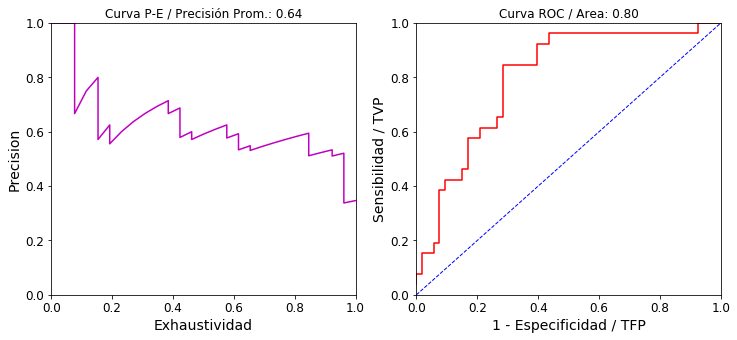

In [30]:
scores = model_1.decision_function(X_test)

precisions, recalls, pr_thresholds = precision_recall_curve(y_test, scores, pos_label=1)
fpr, tpr, roc_thresholds = roc_curve(y_test, scores, pos_label=1)
roc_score = roc_auc_score(y_test, scores, average='weighted')  # area bajo la curva
ap_score = average_precision_score(y_test, scores)  # precisión promedio

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()
plot_precision_recall_curve(precisions, recalls, axes[0])
plot_roc_curve(fpr, tpr, axes[1])
axes[0].set_title('Curva P-E / Precisión Prom.: {0:.2f}'.format(ap_score))
axes[1].set_title('Curva ROC / Area: {0:.2f}'.format(roc_score))

Valores más cercanos a intersección: 0.654 / 0.717


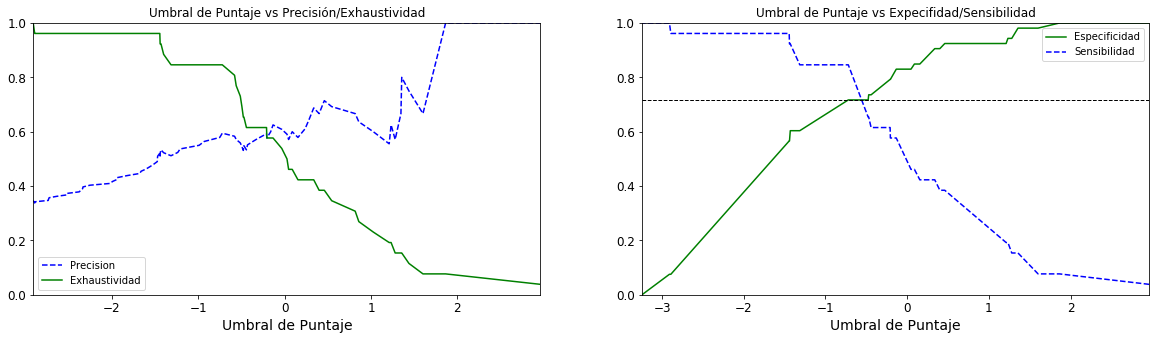

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.ravel()

plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds, ax=axes[0])
plot_specificity_sensitivity_vs_threshold(1 - fpr, tpr, roc_thresholds, ax=axes[1])

cross_idx = np.where(np.abs(tpr - (1 - fpr)) == np.abs(tpr - (1 - fpr)).min())[0]
axes[1].axhline((1-fpr)[cross_idx], lw=1, color='k', linestyle='dashed')
print('Valores más cercanos a intersección: {0:.3f} / {1:.3f}'.format(tpr[cross_idx][0], (1 - fpr)[cross_idx][0]))

### Pipeline 2
- Dataset con columnas `insulin` y `skin`
- Dataset sin 0s incongruentes provenientes de `glucose` (glucosa), `pressure` (presión sanguínea) y `bmi` (índice masa corporal).
- <span style='color: green'>Dataset estandarizado (z-score)</span>
- Regresión Logística con Regularización
- El parámetro de regularización ($C$) se aprende con validación cruzada usando 5 sub-conjuntos ($K=5$)

In [32]:
preprocess_pipeline = Pipeline([
    ('selector', DataFrameSelector(cols_modify, drop_zeros=True)),
    ('std_scaler', StandardScaler())
])

data_2 = preprocess_pipeline.fit_transform(data)
y_2 = preprocess_pipeline.steps[1][1].inverse_transform(data_2)[:, label_idx]
X_2 = np.delete(data_2, label_idx, axis=1)

print('Tamaño del set de datos: {0}'.format(len(data_2)))
print('Proporción respecto a tamaño original: {0:.2f}'.format(len(data_2)/len(data)))

Tamaño del set de datos: 392
Proporción respecto a tamaño original: 0.51


In [33]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(X_2, y_2):
    X_train, X_test = X_2[train_index], X_2[test_index]
    y_train, y_test = y_2[train_index], y_2[test_index]

In [34]:
model_2 = LogisticRegressionCV(cv=5)
model_2.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Text(0.5,1,'Curva ROC / Area: 0.81')

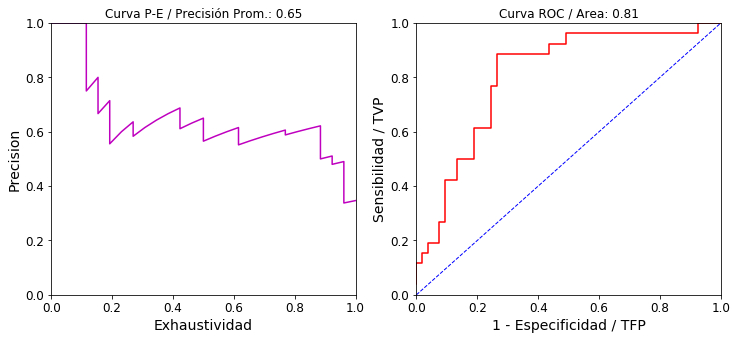

In [35]:
scores = model_2.decision_function(X_test)

precisions, recalls, pr_thresholds = precision_recall_curve(y_test, scores, pos_label=1)
fpr, tpr, roc_thresholds = roc_curve(y_test, scores, pos_label=1)
roc_score = roc_auc_score(y_test, scores, average='weighted')  # area bajo la curva
ap_score = average_precision_score(y_test, scores)  # precisión promedio

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()
plot_precision_recall_curve(precisions, recalls, axes[0])
plot_roc_curve(fpr, tpr, axes[1])
axes[0].set_title('Curva P-E / Precisión Prom.: {0:.2f}'.format(ap_score))
axes[1].set_title('Curva ROC / Area: {0:.2f}'.format(roc_score))

Valores más cercanos a intersección: 0.769 / 0.755


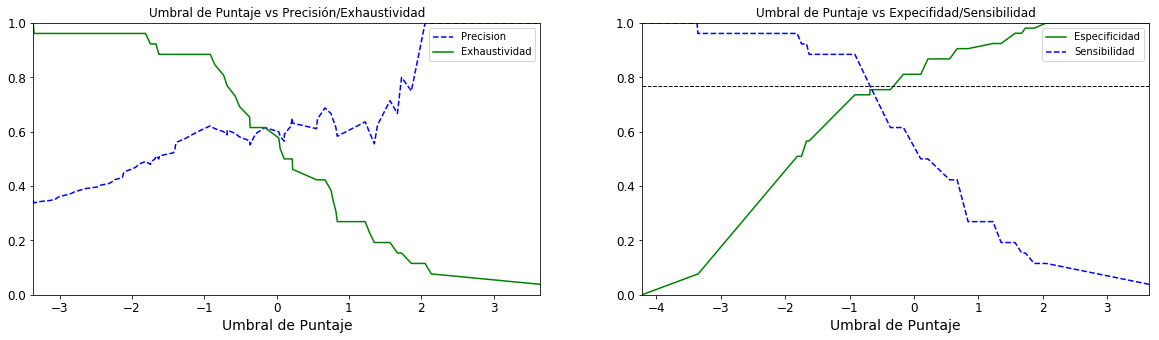

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.ravel()

plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds, ax=axes[0])
plot_specificity_sensitivity_vs_threshold(1 - fpr, tpr, roc_thresholds, ax=axes[1])

cross_idx = np.where(np.abs(tpr - (1 - fpr)) == np.abs(tpr - (1 - fpr)).min())[0]
axes[1].axhline(tpr[cross_idx], lw=1, color='k', linestyle='dashed')
print('Valores más cercanos a intersección: {0:.3f} / {1:.3f}'.format(tpr[cross_idx][0], (1 - fpr)[cross_idx][0]))

### Pipeline 3
- Dataset con columnas `insulin` y `skin`
- <span style='color: green'>Dataset con 0s incongruentes provenientes de `glucose` (glucosa), `pressure` (presión sanguínea), `bmi` (índice masa corporal), `insulin` (insulina) y `skin` (grosor triceps)</span>
- <span style='color: green'>0s incongruentes son imputados con la mediana</span>
- Dataset estandarizado (z-score)
- Regresión Logística con Regularización
- El parámetro de regularización ($C$) se aprende con validación cruzada usando 5 sub-conjuntos ($K=5$)

In [37]:
preprocess_pipeline = Pipeline([
    ('selector', DataFrameSelector(cols_modify, drop_zeros=False)),
    ('zero_to_nan', ZeroToNanConverter()),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

data_3 = preprocess_pipeline.fit_transform(data)
y_3 = preprocess_pipeline.steps[3][1].inverse_transform(data_3)[:, label_idx]
X_3 = np.delete(data_3, label_idx, axis=1)

print('Tamaño del set de datos: {0}'.format(len(data_3)))
print('Proporción respecto a tamaño original: {0:.2f}'.format(len(data_3)/len(data)))

Tamaño del set de datos: 768
Proporción respecto a tamaño original: 1.00


In [38]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(X_3, y_3):
    X_train, X_test = X_3[train_index], X_3[test_index]
    y_train, y_test = y_3[train_index], y_3[test_index]

In [39]:
model_3 = LogisticRegressionCV(cv=5)
model_3.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Text(0.5,1,'Curva ROC / Area: 0.87')

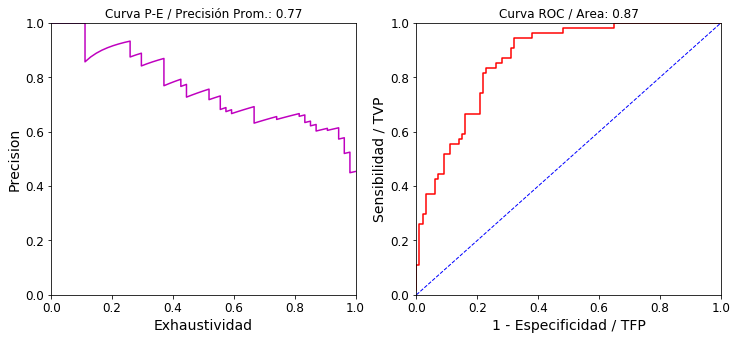

In [40]:
scores = model_3.decision_function(X_test)

precisions, recalls, pr_thresholds = precision_recall_curve(y_test, scores, pos_label=1)
fpr, tpr, roc_thresholds = roc_curve(y_test, scores, pos_label=1)
roc_score = roc_auc_score(y_test, scores, average='weighted')  # area bajo la curva
ap_score = average_precision_score(y_test, scores)  # precisión promedio

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()
plot_precision_recall_curve(precisions, recalls, axes[0])
plot_roc_curve(fpr, tpr, axes[1])
axes[0].set_title('Curva P-E / Precisión Prom.: {0:.2f}'.format(ap_score))
axes[1].set_title('Curva ROC / Area: {0:.2f}'.format(roc_score))

Valores más cercanos a intersección: 0.815 / 0.780


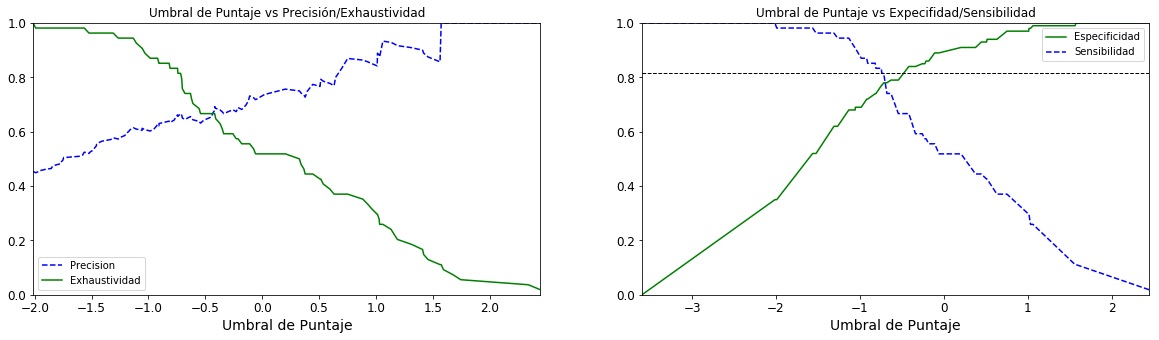

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.ravel()

plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds, ax=axes[0])
plot_specificity_sensitivity_vs_threshold(1 - fpr, tpr, roc_thresholds, ax=axes[1])

cross_idx = np.where(np.abs(tpr - (1 - fpr)) == np.abs(tpr - (1 - fpr)).min())[0]
axes[1].axhline(tpr[cross_idx], lw=1, color='k', linestyle='dashed')
print('Valores más cercanos a intersección: {0:.3f} / {1:.3f}'.format(tpr[cross_idx][0], (1 - fpr)[cross_idx][0]))

### Pipeline 4
- <span style='color: green'>Dataset sin columnas `insulin` y `skin`</span>
- <span style='color: green'>Dataset con 0s incongruentes provenientes de `glucose` (glucosa), `pressure` (presión sanguínea) y `bmi` (índice masa corporal)</span>
- 0s incongruentes son imputados con la mediana
- Dataset estandarizado (z-score)
- Regresión Logística con Regularización
- El parámetro de regularización ($C$) se aprende con validación cruzada usando 5 sub-conjuntos ($K=5$)

In [42]:
preprocess_pipeline = Pipeline([
    ('selector', DataFrameSelector(cols_modify[:3], drop_zeros=False)),
    ('zero_to_nan', ZeroToNanConverter()),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

data_4 = preprocess_pipeline.fit_transform(data)
y_4 = preprocess_pipeline.steps[3][1].inverse_transform(data_4)[:, label_idx]
X_4 = np.delete(data_4, label_idx, axis=1)

print('Tamaño del set de datos: {0}'.format(len(data_4)))
print('Proporción respecto a tamaño original: {0:.2f}'.format(len(data_4)/len(data)))

Tamaño del set de datos: 768
Proporción respecto a tamaño original: 1.00


In [43]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(X_4, y_4):
    X_train, X_test = X_4[train_index], X_4[test_index]
    y_train, y_test = y_4[train_index], y_4[test_index]

In [44]:
model_4 = LogisticRegressionCV(cv=5)
model_4.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

Text(0.5,1,'Curva ROC / Area: 0.88')

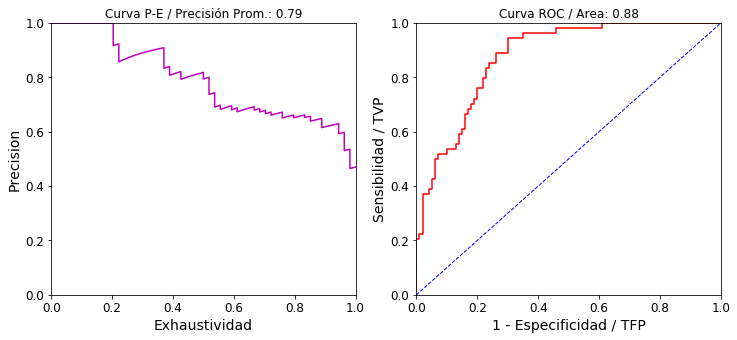

In [45]:
scores = model_4.decision_function(X_test)

precisions, recalls, pr_thresholds = precision_recall_curve(y_test, scores, pos_label=1)
fpr, tpr, roc_thresholds = roc_curve(y_test, scores, pos_label=1)
roc_score = roc_auc_score(y_test, scores, average='weighted')  # area bajo la curva
ap_score = average_precision_score(y_test, scores)  # precisión promedio

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()
plot_precision_recall_curve(precisions, recalls, axes[0])
plot_roc_curve(fpr, tpr, axes[1])
axes[0].set_title('Curva P-E / Precisión Prom.: {0:.2f}'.format(ap_score))
axes[1].set_title('Curva ROC / Area: {0:.2f}'.format(roc_score))

Valores más cercanos a intersección: 0.796 / 0.780


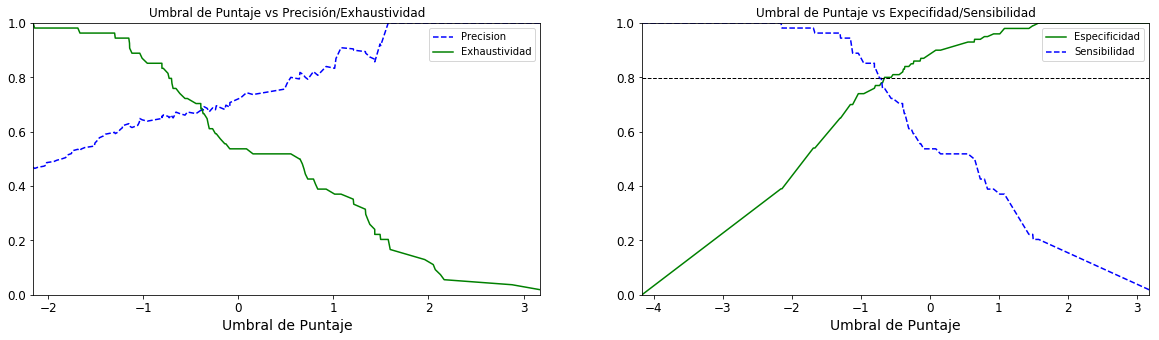

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.ravel()

plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds, ax=axes[0])
plot_specificity_sensitivity_vs_threshold(1 - fpr, tpr, roc_thresholds, ax=axes[1])

cross_idx = np.where(np.abs(tpr - (1 - fpr)) == np.abs(tpr - (1 - fpr)).min())[0]
axes[1].axhline(tpr[cross_idx], lw=1, color='k', linestyle='dashed')
print('Valores más cercanos a intersección: {0:.3f} / {1:.3f}'.format(tpr[cross_idx][0], (1 - fpr)[cross_idx][0]))

### Pipeline 5

- Dataset sin columnas `insulin` y `skin`
- Dataset con 0s incongruentes provenientes de `glucose` (glucosa), `pressure` (presión sanguínea) y `bmi` (índice masa corporal)
- 0s incongruentes son imputados con la mediana
- Dataset estandarizado (z-score)
- Regresión Logística con Regularización
- El parámetro de regularización ($C$) se aprende con validación cruzada usando 5 sub-conjuntos ($K=5$)
- <span style='color: green'> Clases balanceadas mediante oversampling</span>

En este caso el Oversampling se hace solamente sobre el conjunto de prueba para evitar sesgo. El algoritmo escogido será SMOTE ya que genera puntos sintéticos y no es una re-selección aleatoria de puntos existentes.

In [47]:
preprocess_pipeline = Pipeline([
    ('selector', DataFrameSelector(cols_modify[:3], drop_zeros=False)),
    ('zero_to_nan', ZeroToNanConverter()),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

data_5 = preprocess_pipeline.fit_transform(data)
y_5 = preprocess_pipeline.steps[3][1].inverse_transform(data_5)[:, label_idx]
X_5 = np.delete(data_5, label_idx, axis=1)

print('Tamaño del set de datos: {0}'.format(len(data_5)))
print('Proporción respecto a tamaño original: {0:.2f}'.format(len(data_5)/len(data)))

Tamaño del set de datos: 768
Proporción respecto a tamaño original: 1.00


In [48]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(X_5, y_5):
    X_train, X_test = X_5[train_index], X_5[test_index]
    y_train, y_test = y_5[train_index], y_5[test_index]
    
# Oversampling
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=42).fit_sample(X_train, y_train)

In [49]:
model_5 = LogisticRegressionCV(cv=5)
model_5.fit(X_resampled, y_resampled)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

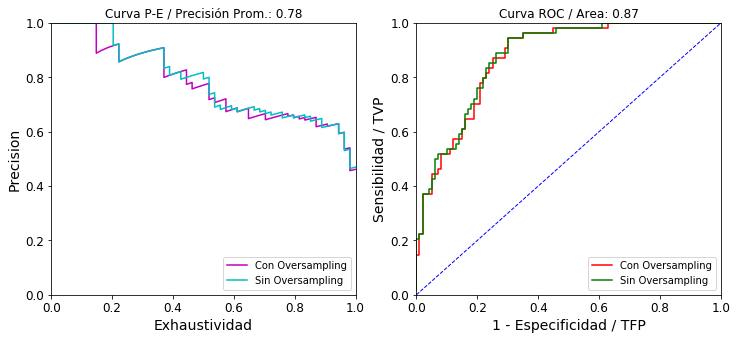

In [50]:
scores = model_5.decision_function(X_test)

precisions, recalls, pr_thresholds = precision_recall_curve(y_test, scores, pos_label=1)
fpr, tpr, roc_thresholds = roc_curve(y_test, scores, pos_label=1)
roc_score = roc_auc_score(y_test, scores, average='weighted')  # area bajo la curva
ap_score = average_precision_score(y_test, scores)  # precisión promedio

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()
plot_precision_recall_curve(precisions, recalls, axes[0])
plot_roc_curve(fpr, tpr, axes[1])
axes[0].set_title('Curva P-E / Precisión Prom.: {0:.2f}'.format(ap_score))
axes[1].set_title('Curva ROC / Area: {0:.2f}'.format(roc_score))

# Comparar con puntajes anteriores (mismo modelo sin oversampling)
prev_scores = model_4.decision_function(X_test)
prev_precisions, prev_recalls, prev_pr_thresholds = precision_recall_curve(y_test, prev_scores, pos_label=1)
prev_fpr, prev_tpr, prev_roc_thresholds = roc_curve(y_test, prev_scores, pos_label=1)
prev_roc_score = roc_auc_score(y_test, prev_scores, average='weighted')  # area bajo la curva
prev_ap_score = average_precision_score(y_test, prev_scores)  # precisión promedio

axes[0].plot(prev_recalls, prev_precisions, 'c-')
axes[1].plot(prev_fpr, prev_tpr, 'g-')

axes[0].legend(['Con Oversampling', 'Sin Oversampling'], loc=4)
axes[1].legend(['Con Oversampling', 'Sin Oversampling'], loc=4)

Valores más cercanos a intersección: 0.778 / 0.780


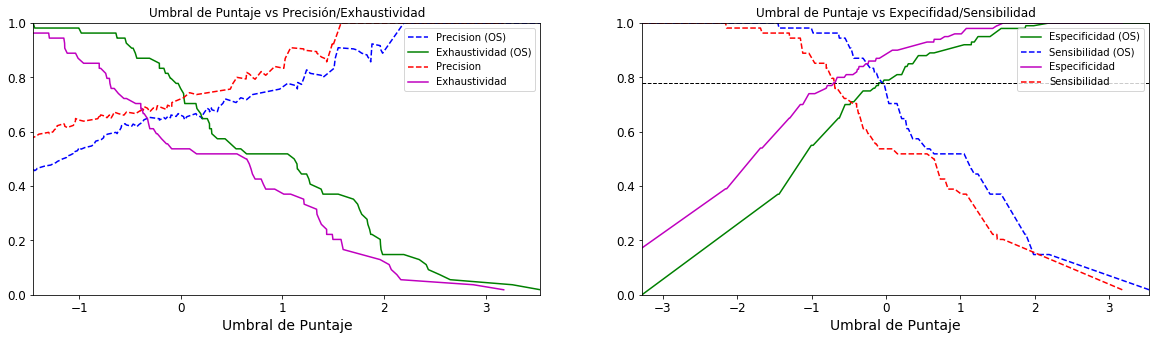

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.ravel()

plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds, ax=axes[0])
plot_specificity_sensitivity_vs_threshold(1 - fpr, tpr, roc_thresholds, ax=axes[1])

cross_idx = np.where(np.abs(tpr - (1 - fpr)) == np.abs(tpr - (1 - fpr)).min())[0]
axes[1].axhline(tpr[cross_idx], lw=1, color='k', linestyle='dashed', label='_nolegend_')
print('Valores más cercanos a intersección: {0:.3f} / {1:.3f}'.format(tpr[cross_idx][0], (1 - fpr)[cross_idx][0]))

# Comparar con puntajes anteriores (mismo modelo sin oversampling)
axes[0].plot(prev_pr_thresholds, prev_precisions[:-1], 'r--')
axes[0].plot(prev_pr_thresholds, prev_recalls[:-1], 'm-')
axes[0].legend(['Precision (OS)', 'Exhaustividad (OS)', 'Precision', 'Exhaustividad'], loc=1)
axes[1].plot(prev_roc_thresholds, (1 - prev_fpr), 'm-')
axes[1].plot(prev_roc_thresholds, prev_tpr, 'r--')
axes[1].legend(['Especificidad (OS)', 'Sensibilidad (OS)', 'Especificidad', 'Sensibilidad'], loc=1)

Este gráfico es muy interesante pues nos muestra el comportamiento antes y después de hacer Oversampling. Notemos que:

- Antes del Oversampling, se tienen muestras de 400 no-diabéticos y 214 diabéticos.
- Después del Oversampling, se tienen muestras de 400 no-diabéticos y 400 diabéticos.
- Las curvas ROC se mantienen similares, con un ligero desfase de umbral de selección que no afecta notoriamente el resultado.
- En las curvas Precisión-Exhaustividad se ve un importante desfase de la Exhaustividad que podría afectar negativamente la toma de decisiones del modelo. Tomar en cuenta que esto también puede deberse a la naturaleza probabilística de SMOT.

Supongamos que la diabetes fuera más importante de detectar que la ausencia de diabetes. Ahora, supongamos que deseamos un modelo con no menos del $95\%$ de Precisión. Esto significaría que con Oversampling, el modelo tendría aproximadamente un $10\%$ de Exhaustividad, mientras que sin Oversampling tendría $20\%$ (el doble!). Esto en simples palabras significa que sin Oversampling tendremos muchos más verdaderos positivos que entrenando con Oversampling. Si optamos por un umbral de decisión más balanceado, no observaremos diferencias significativas.

### Discusión

#### Resumen de Experimentos

| Pipeline ID   | Con `skin`/`test` | Estandarizado | Imputación | Oversampling | Nº muestras | Sensibilidad (1)  | Especificidad (1) | Área ROC | Precision Prom. |
|:-------------:|-------------------|---------------|------------|--------------|-------------|-------------------|-------------------|----------|-----------------|
| (Caso base) 0 | ✗                              | ✗                      | ✗                 | ✗                     | 724         | 0.800             | 0.821             | 0.87     | 0.76            |
| 1             | ✓                              | ✗                      | ✗                 | ✗                     | 392         | 0.654             | 0.717             | 0.80     | 0.64            |
| 2             | ✓                              | ✓                      | ✗                 | ✗                     | 392         | 0.769             | 0.755             | 0.81     | 0.65            |
| 3             | ✓                              | ✓                      | ✓                 | ✗                     | 768         | 0.815             | 0.780             | 0.87     | 0.77            |
| 4             | ✗                              | ✓                      | ✓                 | ✗                     | 768         | 0.796             | 0.780             | 0.88     | 0.79            |
| 5             | ✓                              | ✓                      | ✓                 | ✓                     | 768         | 0.778             | 0.780             | 0.87     | 0.78            |

- (1) Los valores de Sensibilidad-Especificidad corresponden a los más cercanos a la intersección entre ambos.

En base los resultados anteriores podemos observamos que:

- Estandarizar ayuda ligeramente a la exactitud del modelo. Esto tiene sentido porque la estandarización es una técnica que mitiga las diferencias que puede haber entre los distintos tipos de unidades que gobiernan a las características.
- Conservar las columnas `skin`, `test`, y borrar los 0s incongruentes (i.e. sin imputar) permite entrenar un clasificador que a priori rinde peor en todos los casos. Este resultado es cuestionable como mencionamos anteriormente, debido al tamaño menor del conjunto de prueba y de la capacidad de obtener muestras que siempre contengan todas las características.
- Utilizar técnicas de Oversampling para balancear las muestras de diabéticos y no-diabéticos no generó mejores resultados. Si ambas clases son igual de importantes, el clasificador se comporta igual que sin Oversampling. Si la clase diabetes es más importante, el clasificador se comporta igual o peor dependiendo de la razón Precisión-Exhaustividad que se desee, según lo observado en la curva P-E.

## Evaluando otros Clasificadores

Tomando en cuenta la discusión de los resultados anteriores, utilizaremos el *Pipeline 3* para evaluar otros clasificadores que quizás puedan rendir mejor.

In [52]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in split.split(X_3, y_3):
    X_train, X_test = X_3[train_index], X_3[test_index]
    y_train, y_test = y_3[train_index], y_3[test_index]

Dado que cada clasificador tiene sus propios parámetros de diseño (hiper-parámetros), utilizaremos una grilla de parámetros para encontrar aproximadamente los que den la mayor exactitud, para luego comparar las curvas ROC y P-E del mejor modelo en cada caso.

In [53]:
from sklearn.model_selection import GridSearchCV

### Support Vector Machines

In [54]:
from sklearn.svm import SVC

search_span = np.hstack([np.logspace(-3, 3, 7), 3 * np.logspace(-3, 3, 7)])
scoring = ['average_precision', 'roc_auc']
param_grid = {
    'C': search_span,
    'gamma': search_span
}

svc_scores = []
# get the best parameters for either average precision or roc area under curve
for scorer in scoring:
    svc_model = GridSearchCV(SVC(kernel='rbf'), cv=5, param_grid=param_grid, scoring=scorer)
    svc_model.fit(X_train, y_train)
    print('{0} best params: {1}'.format(scorer, svc_model.best_params_))
    svc_scores.append(svc_model.decision_function(X_test))

average_precision best params: {'C': 10.0, 'gamma': 0.0030000000000000001}
roc_auc best params: {'C': 300.0, 'gamma': 0.001}


### Random Forests

In [55]:
from sklearn.ensemble import RandomForestClassifier

scoring = ['average_precision', 'roc_auc']
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': [*range(1, 9)],
    'bootstrap': [True, False]
}

rf_scores = []
# get the best parameters for either average precision or roc area under curve
for scorer in scoring:
    rf_model = GridSearchCV(RandomForestClassifier(random_state=SEED), cv=5, param_grid=param_grid, scoring=scorer)
    rf_model.fit(X_train, y_train)
    print('{0} best params: {1}'.format(scorer, rf_model.best_params_))
    rf_scores.append(rf_model.predict_proba(X_test)[:, 1])

average_precision best params: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 2}
roc_auc best params: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 2}


Algo interesante adicional que se puede hacer es ver la importancia de cada característica desde la perspectiva del *Random Forest*

Text(0,0.5,'Característica')

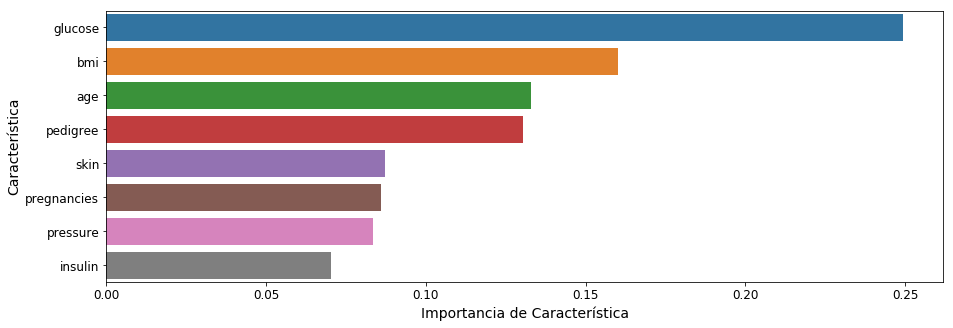

In [56]:
rf_idx = cols_normal[:3] + cols_modify
rf_imp = rf_model.best_estimator_.feature_importances_
rf_std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_], axis=0)
rf_data = np.vstack([rf_imp, rf_std]).T

rf_df = pd.DataFrame(
    rf_data,
    index = rf_idx,
    columns=['importance', 'std'])
rf_df.reset_index(level=0, inplace=True)
rf_df.sort_values(by='importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='importance', y='index', data=rf_df, ax=ax, ci=rf_df['std'])

ax.set_xlabel('Importancia de Característica')
ax.set_ylabel('Característica')

Según este clasificador, la cantidad de glucosa en el plasma sanguíneo es el factor más importante (25%), seguido de el índice masa corporal (16%) y luego edad (13%) junto a la función de pedigree de diabetes (13%). El resto de las características parece ser mucho menos significativa para este modelo.

De todas maneras, el caso de la glucosa no es sorpresa, dado que es la única característica que tenía diferencias de distribución marcadas en su histograma para las diferentes clases.

### Extreme Gradient Boosting

In [57]:
import xgboost as xgb

search_span = np.hstack([np.logspace(-3, 1, 5), 3 * np.logspace(-3, 1, 5)])
scoring = ['average_precision', 'roc_auc']
param_grid = {
    'learning_rate': search_span,
    'max_depth': [*range(10)],
}

xgb_scores = []
# get the best parameters for either average precision or roc area under curve
for scorer in scoring:
    clf = xgb.XGBClassifier(objective='binary:logistic', random_state=SEED)
    xgb_model = GridSearchCV(clf, cv=5, param_grid=param_grid, scoring=scorer)
    xgb_model.fit(X_train, y_train)
    print('{0} best params: {1}'.format(scorer, xgb_model.best_params_))
    xgb_scores.append(xgb_model.predict_proba(X_test)[:, 1])

average_precision best params: {'learning_rate': 0.30000000000000004, 'max_depth': 1}
roc_auc best params: {'learning_rate': 0.30000000000000004, 'max_depth': 1}


### Curvas ROC y Curvas Precisión-Exhaustividad

Una vez tenemos todos nuestros clasificadores entrenados con los mejores parámetros dentro del rango de búsqueda, comparamos las curvas ROC y P-E de cada uno, junto al área bajo la curva y la precisión promedio, respectivamente.

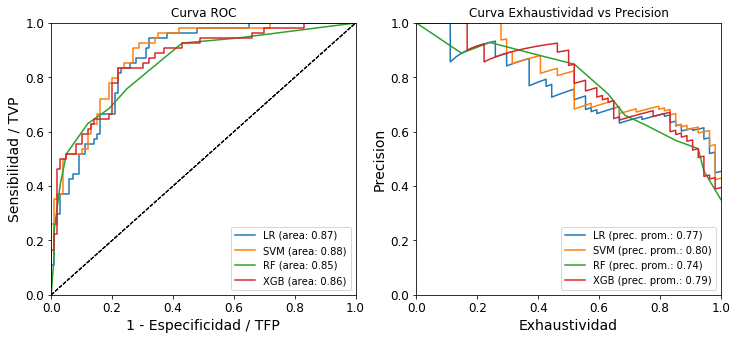

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.ravel()

lr_3_scores = model_3.decision_function(X_test)
lr_3_scores = [lr_3_scores, lr_3_scores]
for model, score in zip(['LR', 'SVM', 'RF', 'XGB'], [lr_3_scores, svc_scores, rf_scores, xgb_scores]):
    precisions, recalls, pr_thresholds = precision_recall_curve(y_test, score[0], pos_label=1)
    ap_score = average_precision_score(y_test, score[0])  # precisión promedio

    fpr, tpr, roc_thresholds = roc_curve(y_test, score[1], pos_label=1)
    roc_score = roc_auc_score(y_test, score[1], average='weighted')  # area bajo la curva
    
    axes[0].plot(fpr, tpr, label='{0} (area: {1:.2f})'.format(model, roc_score))
    axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='_nolegend_')
    axes[1].plot(recalls, precisions, label='{0} (prec. prom.: {1:.2f})'.format(model, ap_score))
    
axes[0].set_xlabel('1 - Especificidad / TFP')
axes[0].set_ylabel('Sensibilidad / TVP')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_title('Curva ROC')
axes[0].legend(loc=4)

axes[1].set_xlabel('Exhaustividad')
axes[1].set_ylabel('Precision')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title('Curva Exhaustividad vs Precision')
axes[1].legend(loc=4)

Como puede observarse, la Regresión Logística y el SVM son los mejores en términos de la curva ROC, mientras que en la curva P-E vemos SVM y XGBoost como los mejores clasificadores. Debido a esto, y dado que no tenemos un criterio definido sobre cómo debería comportarse el modelo, se concluye con que **SVM** es el mejor clasificador para ambos criterios.

Recordemos que esto es válido solamente para las condiciones impuestas. Cualquiera de los siguientes escenarios podrían cambiar drásticamente los resultados obtenidos:

- Tamaño del conjunto de entrenamiento / prueba
- Dataset estratificado / no estratificado
- Semilla de muestreo

La varianza de los números con respecto a los números presentados no es menor. En el [Apéndice B](#Apéndice-B:-Efecto-Semilla) se puede observar qué ocurre con la regresión logística si cambiásemos el parámetro SEED a 42 en vez de 0 para todos los casos. Básicamente lo que ocurre es que los rendimientos bajan drásticamente para todos los casos excepto para los set de datos sub-muestreados (~300 muestras luego de filtrar). Esto es justamente el problema que existe con conjuntos de datos limitados, ya que mientras no existan más datos para entrenar el clasificador, las características muestreadas aleatorias serán cruciales para definir el rendimiento general del clasificador.

Por ahora, un supuesto fuerte que tendremos es que el SVC denominado como el "mejor clasificador" es suficiente para predicción de diabetes en 5 años, y que las muestras del conjunto de prueba no eran fáciles de clasificar. La respuesta esto solo la darán más datos.

## Persistencia de Modelos

Todos los modelos anteriormente entrenados pueden empaquetarse en un archivo que puede ser usado por otra aplicación para servir una API de clasificación o para algún otro propósito.

In [59]:
from sklearn.externals import joblib

def save_model(name, clf, train_feats, train_class, test_feats, test_class):
    model = {
        'clf': clf,
        'train_feats': train_feats,
        'train_class': train_class,
        'test_feats': test_feats,
        'test_class': test_class
    }
    joblib.dump(model, "{0}.pkl".format(name))
    print('Model "{0}" saved'.format(name))

In [60]:
save = False
if save:
    save_model('svm_model', svc_model, X_train, y_train, X_test, y_test)

# Apéndice A: Gráficos Adicionales

## Histogramas

### Sin separación por clase

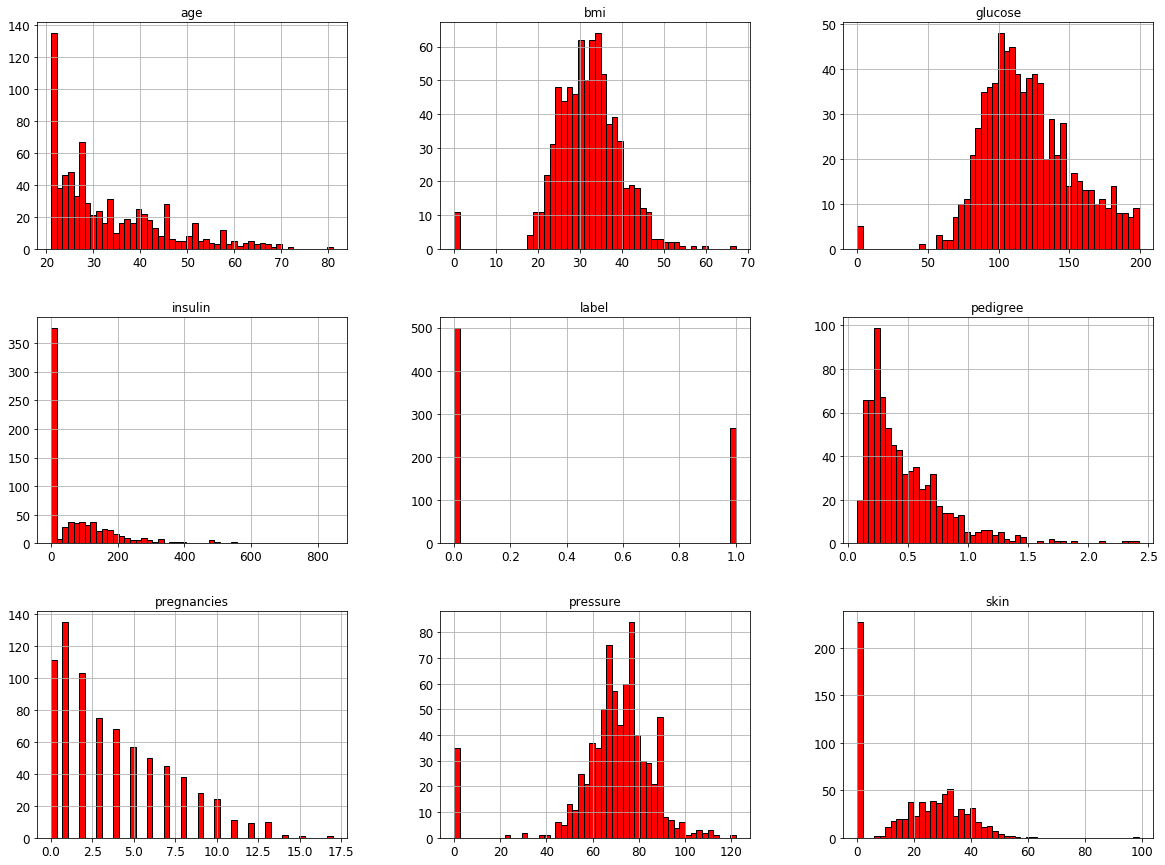

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
_ = data.hist(bins=50, color='r', edgecolor='k', ax=axes)

### Sin 0s en columnas incongruentes

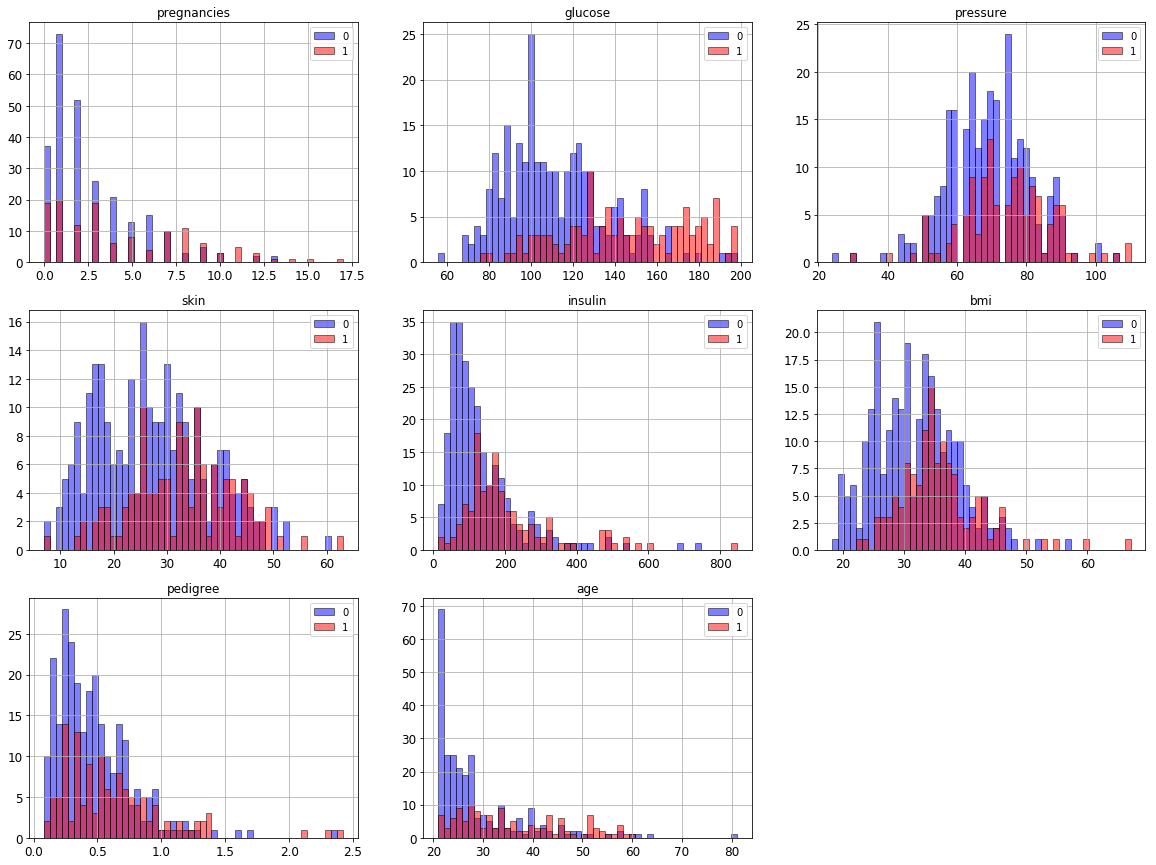

In [62]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

axes = axes.ravel()
fig.delaxes(axes[-1])
for i in range(8):
    ax = axes[i]
    col = df_filtered_1.columns[i]
    lower = df_filtered_1[col].min()
    upper = df_filtered_1[col].max()
    df_filtered_1[df_filtered_1['label'] == 0][col].hist(bins=50, color='b', edgecolor='k', alpha=0.5,
                                  range=(lower, upper), ax=ax, label='0')
    df_filtered_1[df_filtered_1['label'] == 1][col].hist(bins=50, color='r', edgecolor='k', alpha=0.5,
                                  range=(lower, upper), ax=ax, label='1')
    ax.set_title(col)
    ax.legend()

### Sin 0s en columnas incongruentes y sin las columnas `pred` y `skin`

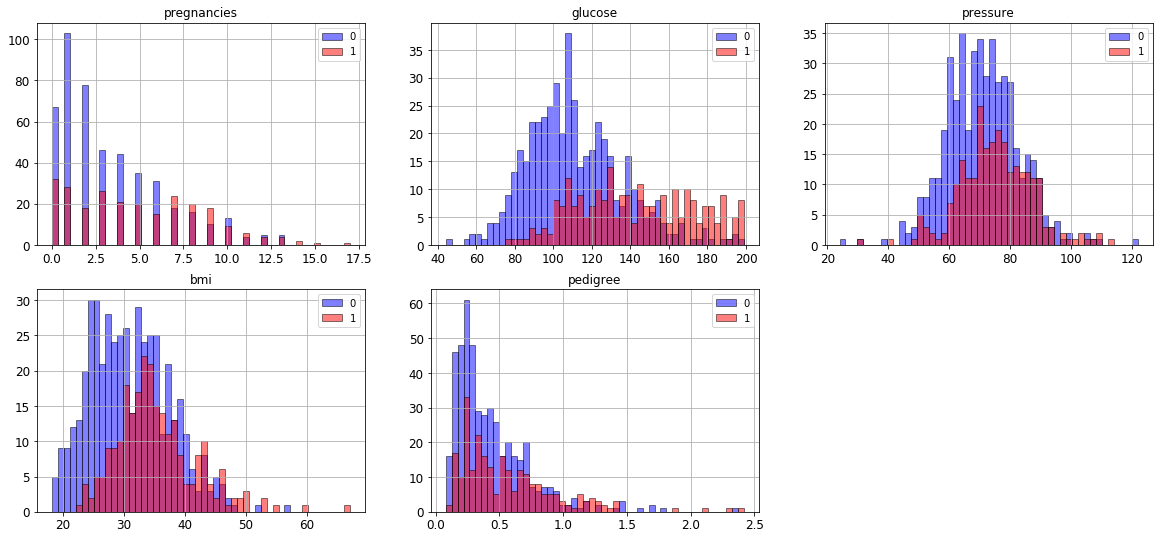

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes = axes.ravel()
fig.delaxes(axes[-1])
for i in range(6):
    ax = axes[i]
    col = df_filtered_2.columns[i]
    lower = df_filtered_2[col].min()
    upper = df_filtered_2[col].max()
    df_filtered_2[df_filtered_2['label'] == 0][col].hist(bins=50, color='b', edgecolor='k', alpha=0.5,
                                  range=(lower, upper), ax=ax, label='0')
    df_filtered_2[df_filtered_2['label'] == 1][col].hist(bins=50, color='r', edgecolor='k', alpha=0.5,
                                  range=(lower, upper), ax=ax, label='1')
    ax.set_title(col)
    ax.legend()

# Apéndice B: Efecto Semilla

![seed.png](seed.png)

Como científicos, no podemos ignorar el efecto que tiene el muestreo en los resultados. Se presenta entonces la tabla de regresión logística para SEED=0.

#### Resumen de Experimentos

| Pipeline ID   | Con `skin`/`test` | Estandarizado | Imputación | Oversampling | Nº muestras | Sensibilidad (1)  | Especificidad (1) | Área ROC | Precision Prom. |
|:-------------:|-------------------|---------------|------------|--------------|-------------|-------------------|-------------------|----------|-----------------|
| (Caso base) 0 | ✗                              | ✗                      | ✗                 | ✗                     | 724         | 0.680             | 0.684             | 0.75     | 0.59            |
| 1             | ✓                              | ✗                      | ✗                 | ✗                     | 392         | 0.808             | 0.849             | 0.87     | 0.82            |
| 2             | ✓                              | ✓                      | ✗                 | ✗                     | 392         | 0.808             | 0.792             | **0.89**     | **0.86**            |
| 3             | ✓                              | ✓                      | ✓                 | ✗                     | **768**         | 0.741             | 0.730             | 0.81     | 0.67            |
| 4             | ✗                              | ✓                      | ✓                 | ✗                     | **768**         | 0.722             | 0.730             | 0.81     | 0.67            |
| 5             | ✓                              | ✓                      | ✓                 | ✓                     | **768**         | 0.741             | 0.730             | 0.81     | 0.65            |

- (1) Los valores de Sensibilidad-Especificidad corresponden a los más cercanos a la intersección entre ambos.

Notemos que ahora los mejores clasificadores son los pipelines 1 y 2, que corresponden al uso de `skin` y `test` con borrado de 0s, dejando la mitad del set de datos disponible para entrenar y evaluar. ¿Por qué ahora los otros casos funcionan peor? Por ejemplo, el área ROC del pipeline 1 bajó de $0.87$ a $0.75$, y su precisión promedio bajó de $0.76$ a $0.59$. Estas bajas son considerables, y como hemos mencionado reiteradas veces, puede ser efecto de muestrear características informativas al entrenar o muestras difíciles de clasificar, con respecto a los conjuntos muestreados con una semilla de 0. 